In [256]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

In [257]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model

In [258]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
#from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [259]:
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles

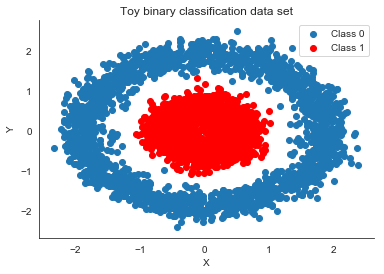

In [260]:
X, Y = make_circles(noise=0.1, factor=0.3, random_state=1, n_samples=4000, shuffle=True)
#X, Y = make_moons(noise=0.2, random_state=0, n_samples=4000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [329]:
dim_num_dense_nodes = Integer(low=2, high=40, name='num_dense_nodes')

In [330]:
dimensions = [dim_num_dense_nodes]

In [331]:
default_parameters = [2]

In [332]:
def create_model(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = keras.Sequential([
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.sigmoid, input_shape=(2,)),
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.sigmoid),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    
    
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = tf.keras.optimizers.Adam()
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [359]:
best_accuracy = 0.0
best_parameter = 0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

In [360]:
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('num_dense_nodes:', num_dense_nodes)
   
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(num_dense_nodes=num_dense_nodes)

 
    # Use Keras to train the model.
    history = model.fit(x=X_train,
                        y=Y_train,
                        epochs=20,
                        validation_data=(X_test, Y_test)
                       )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    
    pred= model.predict(X_test)
    

    ### for graph only
    temp1 = pred<0.5
    temp2 = pred>=0.5

    pred2 = []
    for x in temp1:
        for j in x:
            pred2.append(j)
    pred3 = []
    for x in temp2:
        for j in x:
            pred3.append(j)


    # output graph
    fig, ax = plt.subplots()
    ax.scatter(X_test[pred2, 0], X_test[pred2, 1])
    ax.scatter(X_test[pred3, 0], X_test[pred3, 1], color='r')
    sns.despine()
    ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

    
    global parameter_hist
    global acc_hist
    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(accuracy)
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy
    global best_parameter

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Update the classification accuracy.
        best_accuracy = accuracy
        best_parameter = num_dense_nodes

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

num_dense_nodes: 3

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 325us/step - loss: 0.7154 - acc: 0.4965 - val_loss: 0.7042 - val_acc: 0.5035
Epoch 2/20
2000/2000 [==============================] - 0s 149us/step - loss: 0.7033 - acc: 0.4965 - val_loss: 0.6969 - val_acc: 0.5035
Epoch 3/20
2000/2000 [==============================] - 0s 147us/step - loss: 0.6973 - acc: 0.4965 - val_loss: 0.6940 - val_acc: 0.5035
Epoch 4/20
2000/2000 [==============================] - 0s 151us/step - loss: 0.6949 - acc: 0.5260 - val_loss: 0.6929 - val_acc: 0.6345
Epoch 5/20
2000/2000 [==============================] - 0s 137us/step - loss: 0.6941 - acc: 0.6200 - val_loss: 0.6928 - val_acc: 0.6460
Epoch 6/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.6937 - acc: 0.6045 - val_loss: 0.6927 - val_acc: 0.5960
Epoch 7/20
2000/2000 [==============================] - 0s 137us/step - loss: 0.6936 - acc: 0.5655 - val_loss: 0.692

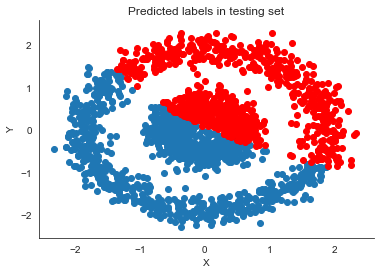

In [361]:

# test a NN with hand pick paranmeter
fitness(x=[3])


# reset all history and best accuracy
best_accuracy = 0.0
best_parameter = 0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

In [362]:
# default parameter is 2 nodes per layer
default_parameters = [2]

num_dense_nodes: 2

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 306us/step - loss: 0.6978 - acc: 0.5035 - val_loss: 0.6967 - val_acc: 0.4965
Epoch 2/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6953 - acc: 0.5035 - val_loss: 0.6950 - val_acc: 0.4965
Epoch 3/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.6941 - acc: 0.5035 - val_loss: 0.6939 - val_acc: 0.4965
Epoch 4/20
2000/2000 [==============================] - 0s 150us/step - loss: 0.6936 - acc: 0.5035 - val_loss: 0.6935 - val_acc: 0.4965
Epoch 5/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.6934 - acc: 0.5035 - val_loss: 0.6932 - val_acc: 0.4965
Epoch 6/20
2000/2000 [==============================] - 0s 209us/step - loss: 0.6932 - acc: 0.5035 - val_loss: 0.6930 - val_acc: 0.4965
Epoch 7/20
2000/2000 [==============================] - 0s 176us/step - loss: 0.6932 - acc: 0.4830 - val_loss: 0.692

2000/2000 [==============================] - 0s 223us/step - loss: 0.6754 - acc: 0.5665 - val_loss: 0.6779 - val_acc: 0.5585
Epoch 20/20
2000/2000 [==============================] - 0s 247us/step - loss: 0.6731 - acc: 0.6065 - val_loss: 0.6756 - val_acc: 0.5690

Accuracy: 56.90%

num_dense_nodes: 39

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 296us/step - loss: 0.7050 - acc: 0.4880 - val_loss: 0.6938 - val_acc: 0.4620
Epoch 2/20
2000/2000 [==============================] - 0s 161us/step - loss: 0.6948 - acc: 0.4860 - val_loss: 0.6934 - val_acc: 0.5035
Epoch 3/20
2000/2000 [==============================] - 1s 278us/step - loss: 0.6943 - acc: 0.4775 - val_loss: 0.6932 - val_acc: 0.5035
Epoch 4/20
2000/2000 [==============================] - 0s 200us/step - loss: 0.6944 - acc: 0.4915 - val_loss: 0.6937 - val_acc: 0.5035
Epoch 5/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6948 - acc: 0.4800 - val_l

2000/2000 [==============================] - 0s 137us/step - loss: 0.6770 - acc: 0.7150 - val_loss: 0.6765 - val_acc: 0.7125
Epoch 18/20
2000/2000 [==============================] - 0s 132us/step - loss: 0.6730 - acc: 0.7495 - val_loss: 0.6728 - val_acc: 0.7525
Epoch 19/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6685 - acc: 0.7575 - val_loss: 0.6681 - val_acc: 0.7685
Epoch 20/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6633 - acc: 0.7640 - val_loss: 0.6621 - val_acc: 0.7615

Accuracy: 76.15%

num_dense_nodes: 12

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 292us/step - loss: 0.7412 - acc: 0.5035 - val_loss: 0.7060 - val_acc: 0.4965
Epoch 2/20
2000/2000 [==============================] - 0s 132us/step - loss: 0.6948 - acc: 0.4840 - val_loss: 0.6934 - val_acc: 0.3360
Epoch 3/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6916 - acc: 0.4825 - val

2000/2000 [==============================] - 0s 138us/step - loss: 0.6915 - acc: 0.5000 - val_loss: 0.6921 - val_acc: 0.5560
Epoch 16/20
2000/2000 [==============================] - 0s 139us/step - loss: 0.6908 - acc: 0.5030 - val_loss: 0.6924 - val_acc: 0.3835
Epoch 17/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6895 - acc: 0.5475 - val_loss: 0.6926 - val_acc: 0.5060
Epoch 18/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6901 - acc: 0.5450 - val_loss: 0.6897 - val_acc: 0.3855
Epoch 19/20
2000/2000 [==============================] - 0s 135us/step - loss: 0.6879 - acc: 0.5485 - val_loss: 0.6936 - val_acc: 0.4965
Epoch 20/20
2000/2000 [==============================] - 0s 135us/step - loss: 0.6849 - acc: 0.5925 - val_loss: 0.6871 - val_acc: 0.4620

Accuracy: 46.20%

num_dense_nodes: 8

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 291us/step - loss: 0.7359 - acc: 0.4965 - va

2000/2000 [==============================] - 0s 138us/step - loss: 0.6889 - acc: 0.5280 - val_loss: 0.6896 - val_acc: 0.6615
Epoch 14/20
2000/2000 [==============================] - 0s 132us/step - loss: 0.6866 - acc: 0.5825 - val_loss: 0.6911 - val_acc: 0.4965
Epoch 15/20
2000/2000 [==============================] - 0s 132us/step - loss: 0.6854 - acc: 0.5845 - val_loss: 0.6860 - val_acc: 0.3535
Epoch 16/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6844 - acc: 0.5430 - val_loss: 0.6845 - val_acc: 0.4965
Epoch 17/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6765 - acc: 0.5695 - val_loss: 0.6760 - val_acc: 0.6520
Epoch 18/20
2000/2000 [==============================] - 0s 137us/step - loss: 0.6716 - acc: 0.6320 - val_loss: 0.6696 - val_acc: 0.5480
Epoch 19/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6619 - acc: 0.6165 - val_loss: 0.6611 - val_acc: 0.6750
Epoch 20/20
2000/2000 [==============================

2000/2000 [==============================] - 0s 137us/step - loss: 0.6894 - acc: 0.5495 - val_loss: 0.6901 - val_acc: 0.6380
Epoch 12/20
2000/2000 [==============================] - 0s 135us/step - loss: 0.6875 - acc: 0.5535 - val_loss: 0.6927 - val_acc: 0.4965
Epoch 13/20
2000/2000 [==============================] - 0s 133us/step - loss: 0.6864 - acc: 0.5635 - val_loss: 0.6896 - val_acc: 0.4965
Epoch 14/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6854 - acc: 0.5375 - val_loss: 0.6831 - val_acc: 0.6725
Epoch 15/20
2000/2000 [==============================] - 0s 133us/step - loss: 0.6791 - acc: 0.6180 - val_loss: 0.6774 - val_acc: 0.7220
Epoch 16/20
2000/2000 [==============================] - 0s 135us/step - loss: 0.6730 - acc: 0.6700 - val_loss: 0.6713 - val_acc: 0.5190
Epoch 17/20
2000/2000 [==============================] - 0s 136us/step - loss: 0.6644 - acc: 0.6610 - val_loss: 0.6589 - val_acc: 0.7340
Epoch 18/20
2000/2000 [==============================

2000/2000 [==============================] - 0s 136us/step - loss: 0.6936 - acc: 0.5300 - val_loss: 0.6936 - val_acc: 0.4370
Epoch 10/20
2000/2000 [==============================] - 0s 133us/step - loss: 0.6940 - acc: 0.4755 - val_loss: 0.6935 - val_acc: 0.6590
Epoch 11/20
2000/2000 [==============================] - 0s 133us/step - loss: 0.6933 - acc: 0.5060 - val_loss: 0.6934 - val_acc: 0.4800
Epoch 12/20
2000/2000 [==============================] - 0s 134us/step - loss: 0.6926 - acc: 0.5145 - val_loss: 0.7010 - val_acc: 0.4965
Epoch 13/20
2000/2000 [==============================] - 0s 139us/step - loss: 0.6930 - acc: 0.5785 - val_loss: 0.6954 - val_acc: 0.4930
Epoch 14/20
2000/2000 [==============================] - 0s 132us/step - loss: 0.6925 - acc: 0.4985 - val_loss: 0.6950 - val_acc: 0.4825
Epoch 15/20
2000/2000 [==============================] - 0s 144us/step - loss: 0.6920 - acc: 0.5185 - val_loss: 0.6941 - val_acc: 0.4000
Epoch 16/20
2000/2000 [==============================

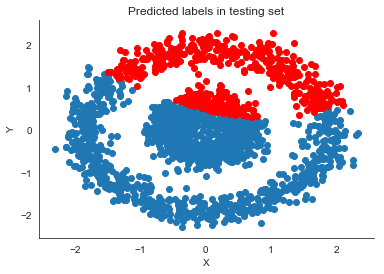

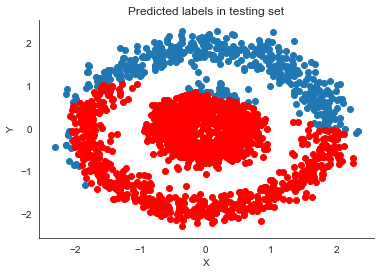

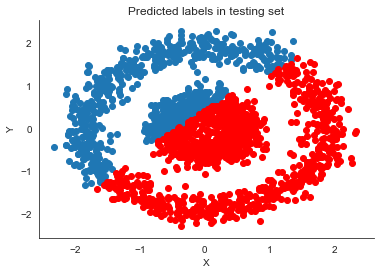

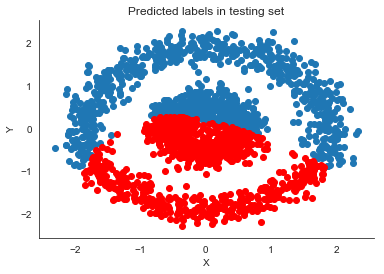

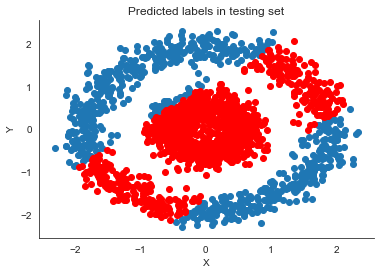

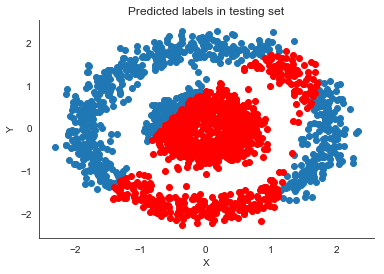

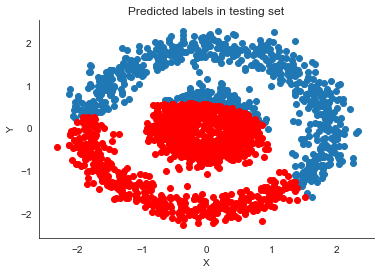

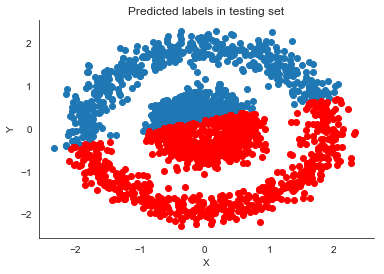

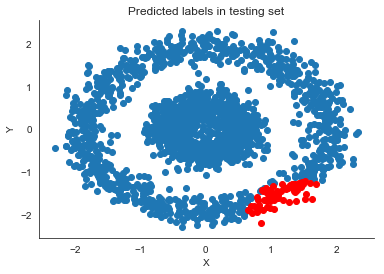

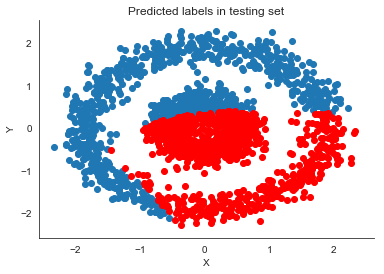

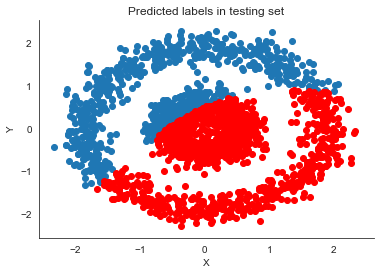

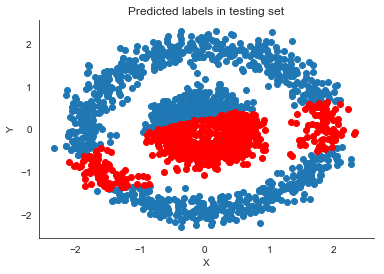

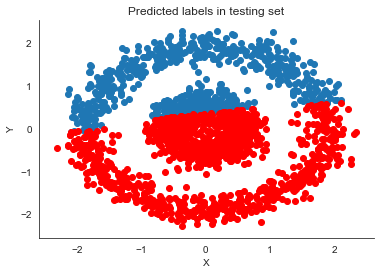

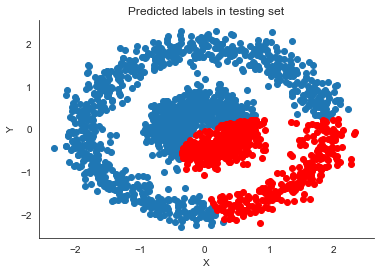

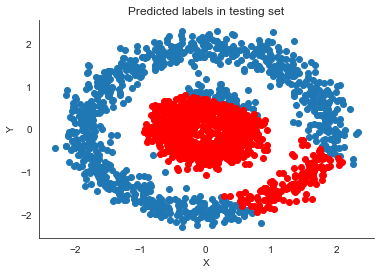

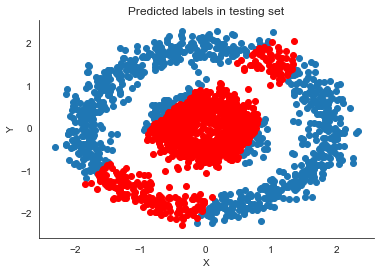

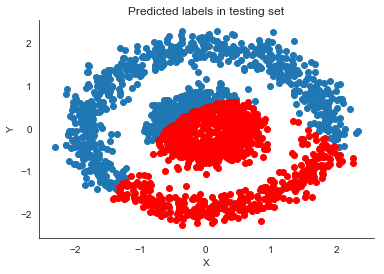

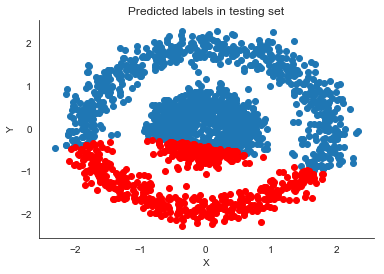

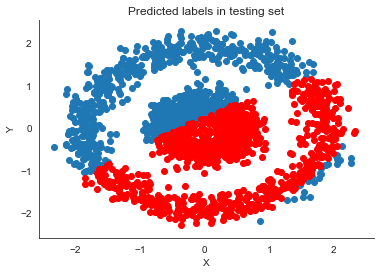

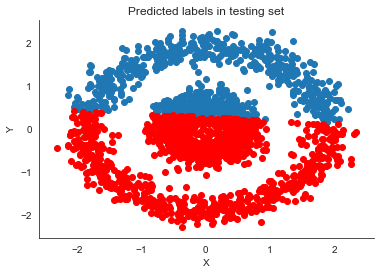

In [363]:
#start searching hyper parameter with gp
# we will do 11 call of fitness function, start with default parameters
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=20,
                            x0=default_parameters)

Text(0.5,1,'Result')

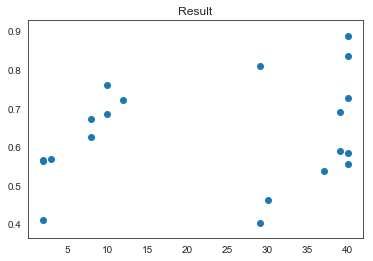

In [366]:
plt.scatter(parameter_hist, acc_hist)
plt.title('Result')


In [367]:
best_accuracy


0.8885

In [368]:
best_parameter

40

In [369]:
parameter_hist

[2, 39, 3, 39, 29, 10, 12, 37, 30, 8, 8, 40, 40, 2, 40, 40, 10, 29, 40, 2]

num_dense_nodes: 40

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 306us/step - loss: 0.6952 - acc: 0.5265 - val_loss: 0.6936 - val_acc: 0.5035
Epoch 2/20
2000/2000 [==============================] - 0s 148us/step - loss: 0.6931 - acc: 0.4860 - val_loss: 0.6958 - val_acc: 0.4965
Epoch 3/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.6952 - acc: 0.4750 - val_loss: 0.6954 - val_acc: 0.4965
Epoch 4/20
2000/2000 [==============================] - 0s 141us/step - loss: 0.6931 - acc: 0.5065 - val_loss: 0.6960 - val_acc: 0.4965
Epoch 5/20
2000/2000 [==============================] - 0s 139us/step - loss: 0.6938 - acc: 0.5080 - val_loss: 0.6996 - val_acc: 0.4965
Epoch 6/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.6959 - acc: 0.5015 - val_loss: 0.6938 - val_acc: 0.5935
Epoch 7/20
2000/2000 [==============================] - 0s 140us/step - loss: 0.6938 - acc: 0.5055 - val_loss: 0.69

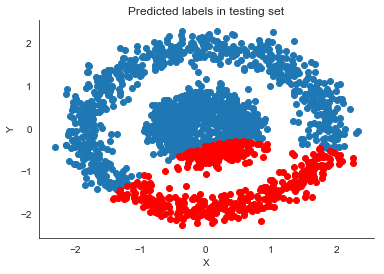

In [371]:
# test a NN with hand pick paranmeter
fitness(x=[40])


# reset all history and best accuracy
best_accuracy = 0.0
best_parameter = 0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

Train on 2000 samples, validate on 2000 samples
Epoch 1/20
2000/2000 [==============================] - 1s 316us/step - loss: 0.6173 - acc: 0.5140 - val_loss: 0.5330 - val_acc: 0.5540
Epoch 2/20
2000/2000 [==============================] - 0s 138us/step - loss: 0.4394 - acc: 0.7935 - val_loss: 0.3431 - val_acc: 0.9525
Epoch 3/20
2000/2000 [==============================] - 0s 150us/step - loss: 0.2461 - acc: 0.9835 - val_loss: 0.1535 - val_acc: 0.9965
Epoch 4/20
2000/2000 [==============================] - 0s 140us/step - loss: 0.0965 - acc: 1.0000 - val_loss: 0.0567 - val_acc: 0.9985
Epoch 5/20
2000/2000 [==============================] - 0s 201us/step - loss: 0.0393 - acc: 1.0000 - val_loss: 0.0280 - val_acc: 0.9985
Epoch 6/20
2000/2000 [==============================] - 0s 233us/step - loss: 0.0211 - acc: 1.0000 - val_loss: 0.0175 - val_acc: 0.9985
Epoch 7/20
2000/2000 [==============================] - 0s 167us/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 0.9990


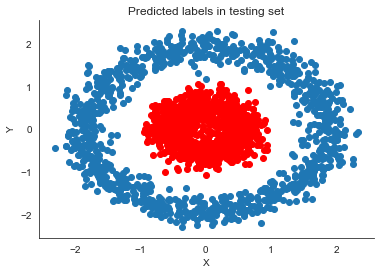

In [380]:
keras_model = keras.Sequential([
    #keras.layers.InputLayer(input_shape=(6549,)),
    #keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(40, activation=tf.nn.relu, input_shape=(2,)),
#    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(40, activation=tf.nn.relu),
    #keras.layers.Dropout(rate=0.3),
#    keras.layers.Dense(40, activation=tf.nn.relu),
#    keras.layers.Dropout(rate=0.3),
#    keras.layers.Dense(512, activation=tf.nn.relu),
#    keras.layers.Dense(512, activation=tf.nn.relu),
#   keras.layers.Dense(11, activation=tf.nn.sigmoid),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


keras_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])


hist = keras_model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test))



### for graph only
pred= keras_model.predict(X_test)
temp1 = pred<0.5
temp2 = pred>=0.5

pred2 = []
for x in temp1:
    for j in x:
        pred2.append(j)
pred3 = []
for x in temp2:
    for j in x:
        pred3.append(j)
        
        
# output graph
fig, ax = plt.subplots()
ax.scatter(X_test[pred2, 0], X_test[pred2, 1])
ax.scatter(X_test[pred3, 0], X_test[pred3, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');


# Delete the Keras model with these hyper-parameters from memory.
del keras_model

# Clear the Keras session, otherwise it will keep adding new
# models to the same TensorFlow graph each time we create
# a model with a different set of hyper-parameters.
K.clear_session()

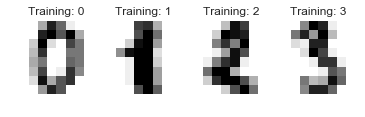

In [201]:
# MNIST dataset
digits = datasets.load_digits()
# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [230]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

X = scale(X)

In [231]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

In [249]:
def create_model(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """
    
    # Start construction of a Keras Sequential model.
    model = keras.Sequential([
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.relu, input_shape=(64,)),
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.relu),
#    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.relu),
#    keras.layers.Dropout(rate=0.3),
#    keras.layers.Dense(512, activation=tf.nn.relu),
#    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(num_dense_nodes, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = tf.keras.optimizers.Adam()
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [250]:

best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

In [253]:
@use_named_args(dimensions=dimensions)
def fitness(num_dense_nodes):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('num_dense_nodes:', num_dense_nodes)
   
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(num_dense_nodes=num_dense_nodes)

 
    # Use Keras to train the model.
    history = model.fit(x=X_train,
                        y=Y_train,
                        epochs=10,
                        validation_data=(X_test, Y_test)
                       )

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # save parameter and accuracy history
    parameter_hist.append(num_dense_nodes)
    acc_hist.append(accuracy)
    
    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
       
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [255]:

# test a NN with hand pick paranmeter
fitness(x=[5])


# reset all history and best accuracy
best_accuracy = 0.0

# keep a list of tried parameter
parameter_hist = []

# keep a list of accuracy hist
acc_hist = []

num_dense_nodes: 5

Train on 1437 samples, validate on 360 samples
Epoch 1/10
1437/1437 [==============================] - 1s 382us/step - loss: 2.3138 - acc: 0.1260 - val_loss: 2.2899 - val_acc: 0.1389
Epoch 2/10
1437/1437 [==============================] - 0s 126us/step - loss: 2.2577 - acc: 0.1608 - val_loss: 2.2358 - val_acc: 0.1722
Epoch 3/10
1437/1437 [==============================] - 0s 138us/step - loss: 2.1761 - acc: 0.1663 - val_loss: 2.1378 - val_acc: 0.1722
Epoch 4/10
1437/1437 [==============================] - 0s 126us/step - loss: 2.0577 - acc: 0.1844 - val_loss: 2.0155 - val_acc: 0.2139
Epoch 5/10
1437/1437 [==============================] - 0s 130us/step - loss: 1.9330 - acc: 0.2450 - val_loss: 1.8967 - val_acc: 0.2333
Epoch 6/10
1437/1437 [==============================] - 0s 134us/step - loss: 1.8094 - acc: 0.2825 - val_loss: 1.7370 - val_acc: 0.3611
Epoch 7/10
1437/1437 [==============================] - 0s 122us/step - loss: 1.6448 - acc: 0.3528 - val_loss: 1.5812

In [248]:
##################################################
keras_model = keras.Sequential([
    #keras.layers.InputLayer(input_shape=(6549,)),
    #keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(64,)),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(rate=0.3),
#    keras.layers.Dense(512, activation=tf.nn.relu),
#    keras.layers.Dropout(rate=0.3),
#    keras.layers.Dense(512, activation=tf.nn.relu),
#    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


keras_model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


hist = keras_model.fit(X_train, Y_train, epochs=2, validation_data=(X_test, Y_test))


Train on 1437 samples, validate on 360 samples
Epoch 1/2
1437/1437 [==============================] - ETA: 0s - loss: 2.1024 - acc: 0.306 - 1s 406us/step - loss: 2.0774 - acc: 0.3264 - val_loss: 1.5597 - val_acc: 0.7194
Epoch 2/2
1437/1437 [==============================] - 0s 136us/step - loss: 1.3220 - acc: 0.6312 - val_loss: 0.7261 - val_acc: 0.8028
